![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)

# Script pour récupérer et superposer les couches météorologiques Radar GeoMet

## Introduction

Web Mapping Services tels que [GeoMet Weather](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) fournissent diverses couches très utiles pour visualiser les événements géospatiaux tels que des tempêtes. Chaque requête `GetMap` valide répond avec une image de la couche demandée, mais manque de carte de base. Ce cahier montre comment créer une carte statique en assemblant un nombre arbitraire de couches sur une carte de base et l'exporter à l'aide de [OWSLib](https://geopython.github.io/OWSLib/).

## Dépendances

OWSLib et PIL sont les deux bibliothèques utilisées et doivent être installées avant d'exécuter d'autres cellules dans ce cahier.
OWSLib est une bibliothèque qui nous permet de faire des requêtes `GetMap` à un `WMS` d'une manière plus naturellement Pythonique tandis que PIL est la bibliothèque qui nous permet de manipuler des images.

In [ ]:
!pip install owslib
from owslib.wms import WebMapService
# !pip install PIL
from PIL import Image
import requests
import io
import warnings

     |████████████████████████████████| 215 kB 13.5 MB/s 
     |████████████████████████████████| 6.6 MB 72.5 MB/s 


## Variables
Une requête `GetMap` typique demande plusieurs choses à l'utilisateur.  

1.   Nom de la couche, dont une liste peut être trouvée sur [GeoMet Weather GetCapabilities](https://geo.weather.gc.ca/geomet?lang=en&service=WMS&version=1.3.0&request=GetCapabilities) ou peut être itérée sur en utilisant OWSLib comme démontré dans leur [documentation](https://geopython.github.io/OWSLib/usage.html#wms)  
(eg. CURRENT_CONDITIONS)
2.   Bounding Box, qui est un 4-tuple des limites de la carte que nous voulons voir.  
(eg. 35.081279,-108.546753,57.212106,-42.493286)
3. La projection de la couche aussi connue en tant que le EPSG ou le CRS.  
(eg. 4326)
4. Taille de l'image sous la forme d'un 2-tuple integer composé de la largeur et de la hauteur.
(eg. 1400, 600)
5. Opacité de la couche également connue sous le nom de canal Alpha de l'image qui est utilisé pour s'assurer qu'aucun calque ne masque les calques empilés en dessous.  
(eg. 0.7)

À titre d'exemple, essayons de composer une carte en utilisant un mélange de couches continues et radar d'une grande région en utilisant les variables ci-dessous.

In [ ]:
list_of_geomet_layers = ['GDPS.ETA_TT',
                      'RADAR_RRAI',
                      'RADAR_RSNO',
                      'RADAR_RDBR',
                      'RADAR_RDBS']
bbox = [35.081279,-108.546753,57.212106,-42.493286] # Assurez-vous qu'il ne dépasse pas les limites du WMS
crs = "EPSG:4326"
width = 1400
height = 600
format = "image/png"
list_of_geomet_images = []
alpha = 0.9
nrcan_basemap_url = "https://maps.geogratis.gc.ca/wms/CBMT?service=wms&version=1.3.0&request=GetMap&layers=CBMT&BBOX={},{},{},{}&CRS={}&WIDTH={}&HEIGHT={}&format={}".format(bbox[0],bbox[1],bbox[2],bbox[3],crs,width,height,format)

## Récupérer les images

Tout d'abord, récupérons le fond de carte à l'aide de la requête `GetMap` que nous avons composée pour le WMS de RNCAN qui sert une carte du Canada.

In [ ]:
basemap = Image.open(requests.get(nrcan_basemap_url, stream=True).raw)
basemap = basemap.convert('RGBA')

La cellule suivante supprime les avertissements et les erreurs de la connexion initiale au `WMS` émis par OWSLib afin de ne pas encombré notre espace de travail.

In [ ]:
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

Ici, nous définissons le `WMS` auquel nous publierons nos demandes et dans cet exemple, nous nous connectons bien sûr au WMS GeoMet Weather.


In [ ]:
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0',
                    timeout=300)

Maintenant que nous sommes connectés, parcourons la liste des couches prédéfinies que nous voulons et effectuons les requêtes `GetMap` qui sont ensuite simplement converties en images Python à l'aide du constructeur Image de PIL.

In [ ]:
for layer in list_of_geomet_layers: 
  temporary_response = wms.getmap(
      layers=[layer],
      srs=crs,
      bbox=(bbox[1], bbox[0], bbox[3], bbox[2]),
      size=(width, height),
      format=format,
      transparent=True)
  temporary_image = Image.open(io.BytesIO(temporary_response.read()))
  temporary_image = temporary_image.convert('RGBA')
  list_of_geomet_images.append(temporary_image)

## Composer l'image finale

Maintenant que nous avons une liste d'images de nos couches et du fond de carte, il ne nous reste plus qu'à les empiler.

In [ ]:
def overlayImage(base, top):
  tmp_img_comp = Image.alpha_composite(base, top)
  tmp_img_comp.putalpha(tmp_img_comp.getchannel('A').point(lambda x: x*alpha))
  return tmp_img_comp

overlays_composite = Image.alpha_composite(list_of_geomet_images[0],list_of_geomet_images[1])

for i in range(2,len(list_of_geomet_images)):
  overlays_composite = overlayImage(overlays_composite,list_of_geomet_images[i])

final_map = Image.alpha_composite(basemap, overlays_composite)

## Exporter l'image finale

Voyons l'image finale avant de l'exporter.

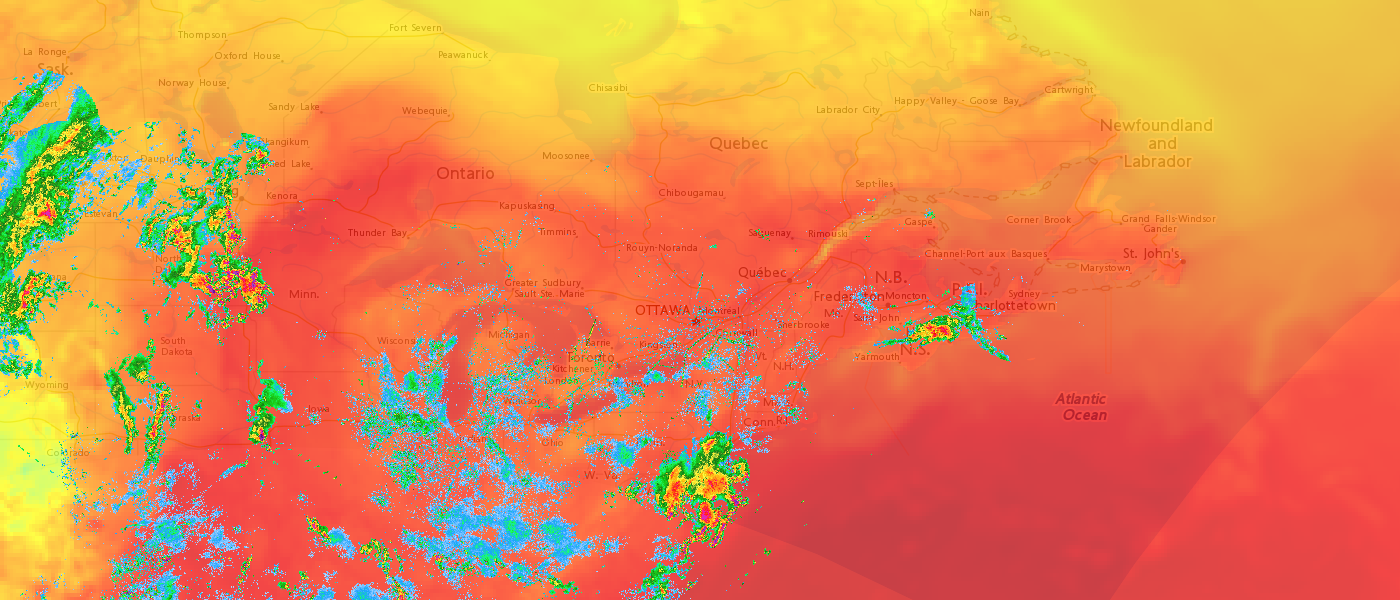

In [ ]:
final_map

Maintenant que nous sommes satisfaits, nous pouvons exporter ou continuer à bricoler avec l'image.

In [ ]:
final_map.save('map.png')

## Annexe
Nous pouvons ajouter une dimension temporelle à notre script et l'utiliser pour créer des GIF à l'aide de la fonction GetCapabilities d'OWSLib


In [ ]:
from datetime import datetime, timedelta
import re 

time_zone = -7
def time_parameters(layer):
    start_time, end_time, interval = (wms[layer]
                                      .dimensions['time']['values'][0]
                                      .split('/')
                                      )
    iso_format = '%Y-%m-%dT%H:%M:%SZ'
    start_time = datetime.strptime(start_time, iso_format)
    end_time = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r'\D', '', interval))
    return start_time, end_time, interval


start_time, end_time, interval = time_parameters('REPS.DIAG.3_PRMM.ERGE5')

time = [start_time]
local_time = [start_time + timedelta(hours=time_zone)]
while time[-1] < end_time:
    time.append(time[-1] + timedelta(hours=interval))
    local_time.append(time[-1] + timedelta(hours=time_zone))

In [ ]:
time